In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from data_processing import text_standardization

2024-01-18 22:30:44.725698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pickle

In [3]:
# load the saved splitted data
train_pairs = pickle.load(open("data/train_pairs.pkl", "rb"))
val_pairs = pickle.load(open("data/val_pairs.pkl", "rb"))
test_pairs = pickle.load(open("data/test_pairs.pkl", "rb"))

In [4]:
# load vectorization for output language
from_disk = pickle.load(open("model/target_vectorization8.pkl", "rb"))
target_vectorization = layers.TextVectorization.from_config(from_disk['config'])

target_vectorization.set_weights(from_disk['weights'])


print(f"output vocabulary:\n{target_vectorization.get_vocabulary()}")

output vocabulary:
['', '[UNK]', 'd', 'a', 'c', 'b', 'f', 'g', 'e', 'h', 'j', 'i', '[start]', '[end]', 'k', 'l', 'm', 'ed', 'ee', 'ef', 'eg', 'eh']


2024-01-18 22:30:48.589582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# load vectorization for input language
from_disk = pickle.load(open("model/source_vectorization8.pkl", "rb"))
source_vectorization = layers.TextVectorization.from_config(from_disk['config'])

source_vectorization.set_weights(from_disk['weights'])


print(f"input vocabulary:\n{source_vectorization.get_vocabulary()}")

input vocabulary:
['', '[UNK]', 'a', 'd', 'c', 'b', 'f', 'g', 'e', 'h']


In [7]:
# dimensions based on the dataset analysis
input_vocab_size = 8 + 2  # +2 for "" and Unkown

# max text length in both input and output text is 47
# but I increased to 55 to account for longer texts that may exist in unseen data
output_seq_len = 55
input_seq_len = output_seq_len
output_vocab_size = 18 + 2 + 2  # +2 for "" and Unkown and +2 for [start] and [end]

# Data Preprocessing

In [8]:
batch_size = 128

In [9]:
def format_dataset(source, target):
    source = source_vectorization(source)
    target = target_vectorization(target)
    return (
    {
        "source": source,
        "translated": target[:, :-1]
        
    }, target[:, 1:])

def make_dataset(source_target_pairs, **kwargs):
    batch_size = kwargs.get("batch_size", 64)
    source_texts, target_texts = zip(*source_target_pairs)
    source_texts = list(source_texts)
    target_texts = list(target_texts)
    # source and target data will be stored in tf dataset
    dataset = tf.data.Dataset.from_tensor_slices((source_texts, target_texts))
    dataset = dataset.batch(batch_size)
    # apply data preprocessing function as in the order they stored in tf dataset
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

In [10]:
train_ds = make_dataset(train_pairs, batch_size=batch_size)
val_ds = make_dataset(val_pairs, batch_size=batch_size)

In [11]:
# debugging purpose
for inputs, targets in train_ds.take(1):
    print(f"inputs source shape: {inputs['source'].shape}")
    print(f"inputs translated shape: {inputs['translated'].shape}")
    print(f"target shape: {targets.shape}")

inputs source shape: (128, 55)
inputs translated shape: (128, 55)
target shape: (128, 55)


2024-01-18 22:30:59.136313: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [12]:
in_vocab = source_vectorization.get_vocabulary()
out_vocab = target_vectorization.get_vocabulary()
print(f"input vocabulary:\n{in_vocab}")
print(f"output vocabulary:\n{out_vocab}")

input vocabulary:
['', '[UNK]', 'a', 'd', 'c', 'b', 'f', 'g', 'e', 'h']
output vocabulary:
['', '[UNK]', 'd', 'a', 'c', 'b', 'f', 'g', 'e', 'h', 'j', 'i', '[start]', '[end]', 'k', 'l', 'm', 'ed', 'ee', 'ef', 'eg', 'eh']


# Model Selection

In [14]:
class SinCosPosEmbed(layers.Layer):
    def __init__(self, seq_len, input_dim, output_dim, **kwargs):
        super().__init__()
        # positional encoding function that maps position of a token to some value represent position
        mask_zero = kwargs.get("mask_zero", False)
        
        self.token_embedding = layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                                                mask_zero=mask_zero)
        self.position_embedding = layers.Embedding(input_dim=seq_len, output_dim=output_dim,
                                                   mask_zero=mask_zero)
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
    
    
    def getSinCosPositionalEncoding(self, **kwargs):
        # positional encoding used by "attention is all you need" paper
        seq_len = kwargs.get("seq_len")
        embed_dim = kwargs.get("embed_dim")
        scalar = kwargs.get("scalar", 10000)
        positions = np.zeros((seq_len, embed_dim))
        for p in range(seq_len):
            for i in range(int(embed_dim/2)):
                denom = np.power(scalar, 2*i/embed_dim)
                positions[p, 2*i] = np.sin(p/denom)
                positions[p, 2*i + 1] = np.cos(p/denom)
        tf.cast(positions, dtype=tf.float32)
        return positions
    
    
    def call(self, inputs):
        length = inputs.shape[1]
        
        # get positional encoding of the input given
        arg_dict = {"inputs": inputs, "seq_len": self.seq_len, "embed_dim": self.output_dim}
        positions = self.getSinCosPositionalEncoding(**arg_dict)
        
        embedded_tokens = self.token_embedding(inputs)
        # scaling embedded_tokens
        embedded_tokens *= tf.math.sqrt(tf.cast(self.output_dim, tf.float32))
        positions[tf.newaxis, :length , :]  # reshaping to have the same shape as token embedding
        return embedded_tokens + positions
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "input_dim": self.input_dim,
            "seq_len": self.seq_len,
        })
        return config


In [112]:
'''
global positional_encoding
positional_encoding = pe

class PositionalEmbedding(layers.Layer):
    def __init__(self, seq_len, input_dim, output_dim, is_pos_embed=False, **kwargs):
        super().__init__()
        # positional encoding function that maps position of a token to some value represent position
        mask_zero = kwargs.get("mask_zero", False)
        
        self.is_pos_embed = is_pos_embed
        self.token_embedding = layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                                                mask_zero=mask_zero)
        self.position_embedding = layers.Embedding(input_dim=seq_len, output_dim=output_dim,
                                                   mask_zero=mask_zero)
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = inputs.shape[1]
        
        arg_dict = {"inputs": inputs, "seq_len": self.seq_len, "embed_dim": self.output_dim}
        positions = positional_encoding(**arg_dict)
        
        embedded_tokens = self.token_embedding(inputs)
        # scaling embedded_tokens
        embedded_tokens *= tf.math.sqrt(tf.cast(self.output_dim, tf.float32))
        if self.is_pos_embed:
            positions = self.position_embedding(positions)
        else:
            positions[tf.newaxis, :length , :]
        return embedded_tokens + positions
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "input_dim": self.input_dim,
            "seq_len": self.seq_len,
            "is_pos_embed": self.is_pos_embed,
        })
        return config
'''

In [15]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__()
        dropout_rate = kwargs.get("dropout_rate",0.0)  # default) no dropout
        self.dropout = layers.Dropout(dropout_rate)
        regularizer = kwargs.get("regularizer")  # keras kernel regularizer
        
        # set up layers for Transformer encoder
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,
                                                   dropout=dropout_rate, kernel_regularizer=regularizer)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
    
    
    def call(self, inputs, mask=None):
        if mask is not None:
            # reshaping mask to ensure each batch has 2D mask(axis0: sequence, axis1: embed_dim) 
            mask = mask[:, tf.newaxis, :]
        # forward propagation
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        dense_input = self.layernorm1(inputs + attention_output)
        dense_output = self.dense_proj(dense_input)
        dense_output = self.dropout(dense_output)
        return self.layernorm2(dense_input + dense_output)
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "dense_dim": self.dense_dim,
            }
        )
        return config

In [16]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__()
        dropout_rate = kwargs.get("dropout_rate",0.0)  # default) no dropout
        self.dropout = layers.Dropout(dropout_rate)
        regularizer = kwargs.get("regularizer")  # keras kernel regularizer
        
        # set up layers for Transformer decoder
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,
                                                   dropout=dropout_rate, kernel_regularizer=regularizer)
        self.attention2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,
                                                   dropout=dropout_rate, kernel_regularizer=regularizer)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.layernorm3 = layers.LayerNormalization()
        self.supports_masking = True
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "dense_dim": self.dense_dim,
            }
        )
        return config
    
    
    def call(self, inputs, encoder_outputs, mask=None):
        # forward propagate
        attention_output1 = self.attention1(query=inputs, value=inputs, key=inputs,
                                           use_causal_mask = True)
        attention_output1 = self.layernorm1(inputs + attention_output1)
        # use encoder outputs as key and value
        attention_output2 = self.attention2(
            query=attention_output1,
            value=encoder_outputs,
            key=encoder_outputs,
        )
        attention_output2 = self.layernorm2(attention_output1 + attention_output2)
        output = self.dense_proj(attention_output2)
        output = self.dropout(output)
        return self.layernorm3(attention_output2 + output)

In [17]:
class TokenGenerator():
    def __init__(self):
        raise NotImplemented
    
    def __call__(self):
        raise NotImplemented

class Generate_tokens(TokenGenerator):
    def __init__(self):
        return
    
    def __call__(self, input_seq, target_vectorization, source_vectorization, model, **kwargs):
        max_out_seq_len = kwargs.get("max_out_seq_len", 30)
        
        out_vocab = target_vectorization.get_vocabulary()
        out_index_lookup = dict(zip(range(len(out_vocab)), out_vocab))  # mapping vectorization to vocab
        tokenized_input_seq = source_vectorization([input_seq])
        decoded_sentence = "[start]"
        for i in range(max_out_seq_len):
            tokenized_out_sentence = target_vectorization([decoded_sentence])[:, :-1]
            # input: 1st elem for encoder, and 2nd elem for the first self-attention layer in decoder
            predictions = model([tokenized_input_seq, tokenized_out_sentence])
            predicted_token_index = np.argmax(predictions[0, i, :])  # a token with highest probabillity
            predicted_token = out_index_lookup[predicted_token_index]
            decoded_sentence += " " + predicted_token
            if predicted_token == "[end]":
                break
        return decoded_sentence

In [18]:
test_input_txt = [pair[0] for pair in test_pairs]
test_target_txt = [pair[1] for pair in test_pairs]

In [19]:
# dimension for Transformer
embed_dim = 16
dense_dim = 128
num_heads = [2,4,8,16, 32, 55]

In [20]:

class AttentionLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    # learning rate schedule used in the "attention is all you need" paper
    def __init__(self, embed_dim, warmup_steps=4000):
        super().__init__()
        self.embed_dim = embed_dim
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        elem1 = tf.math.rsqrt(step)
        elem2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(tf.cast(self.embed_dim, tf.float32)) * tf.math.minimum(elem1, elem2)
    
    def get_config(self):
        config = {
            "embed_dim": self.embed_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config


In [21]:
lr = AttentionLRSchedule(embed_dim)
# optimizer setting followed the "attention is all you need" paper
optim = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [22]:
def masked_loss(label, pred):
    # loss fucntion for machine translation(Cross entropy modified to account for masking)
    mask = label != 0
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_function(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask  # no loss computed for a token that is masked in a sequence
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)  # averaged by the number of non-mask tokens
    return loss
    

def masked_accuracy(label, pred):
    # model accuracy computation accounting for masking
    pred = tf.argmax(pred, axis=-1)
    label = tf.cast(label, pred.dtype)
    accurate = label == pred  # boolean tensor True if predicted correctly
    mask = label != 0
    accurate = accurate & mask  # mark as accurate if correctly predicted and not masked token
    accurate = tf.cast(accurate, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accurate) / tf.reduce_sum(mask)  # averaged by the number of non-mask tokens


In [23]:
dropout_rate=0.1

In [24]:
# multi stacked transformers
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="source")
x = SinCosPosEmbed(input_seq_len, input_vocab_size, embed_dim)(encoder_inputs)
x = layers.Dropout(dropout_rate)(x)
TE = TransformerEncoder(embed_dim, dense_dim, num_heads[0])(x)
TE = TransformerEncoder(embed_dim, dense_dim, num_heads[1])(TE)
TE = TransformerEncoder(embed_dim, dense_dim, num_heads[2])(TE)
TE = TransformerEncoder(embed_dim, dense_dim, num_heads[3])(TE)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="translated")
x = SinCosPosEmbed(output_seq_len, output_vocab_size, embed_dim)(decoder_inputs)
x = layers.Dropout(dropout_rate)(x)
TD = TransformerDecoder(embed_dim, dense_dim, num_heads[0])(x, TE)
TD = TransformerDecoder(embed_dim, dense_dim, num_heads[1])(TD, TE)
TD = TransformerDecoder(embed_dim, dense_dim, num_heads[2])(TD, TE)
TD = TransformerDecoder(embed_dim, dense_dim, num_heads[3])(TD, TE)

x = layers.Dropout(dropout_rate)(TD)

decoder_outputs = layers.Dense(output_vocab_size)(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 sin_cos_pos_embed (SinCosPosEm  (None, 55, 16)      160         ['source[0][0]']                 
 bed)                                                                                             
                                                                                                  
 dropout (Dropout)              (None, 55, 16)       0           ['sin_cos_pos_embed[0][0]']      
                                                                                                  
 transformer_encoder (Transform  (None, 55, 16)      6464        ['dropout[0][0]']            

In [25]:
transformer.compile(loss=masked_loss, optimizer=optim, metrics=[masked_accuracy])

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="model/stack4_transformer.h5", monitor='val_loss',
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=9, verbose=1),
]
history = transformer.fit(train_ds,
                          epochs=30,
                          validation_data=val_ds,
                          callbacks=callbacks)

Epoch 1/30
613/613 [==============================] - 310s 499ms/step - loss: 1.3108 - masked_accuracy: 0.3194 - val_loss: 0.6685 - val_masked_accuracy: 0.5824
Epoch 2/30
613/613 [==============================] - 304s 496ms/step - loss: 0.5683 - masked_accuracy: 0.6268 - val_loss: 0.3790 - val_masked_accuracy: 0.7397
Epoch 3/30
613/613 [==============================] - 304s 496ms/step - loss: 0.3601 - masked_accuracy: 0.7577 - val_loss: 0.2268 - val_masked_accuracy: 0.8465
Epoch 4/30
613/613 [==============================] - 304s 496ms/step - loss: 0.2232 - masked_accuracy: 0.8532 - val_loss: 0.1236 - val_masked_accuracy: 0.9215
Epoch 5/30
613/613 [==============================] - 304s 496ms/step - loss: 0.1315 - masked_accuracy: 0.9174 - val_loss: 0.0587 - val_masked_accuracy: 0.9639
Epoch 6/30
613/613 [==============================] - 304s 496ms/step - loss: 0.0813 - masked_accuracy: 0.9539 - val_loss: 0.0172 - val_masked_accuracy: 0.9906
Epoch 7/30
613/613 [====================

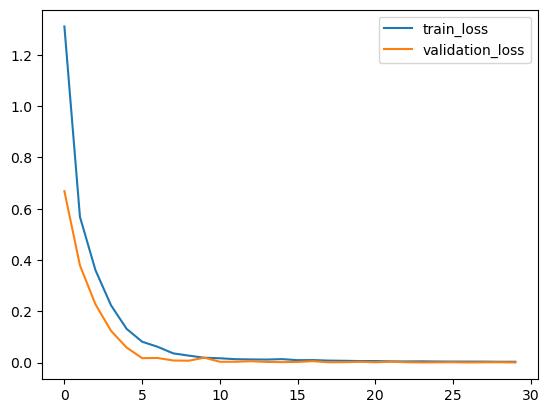

In [27]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss, label="validation_loss")
plt.legend()
plt.show()

In [28]:
transformer = keras.models.load_model("model/stack4_transformer.h5",
                                     custom_objects={
                                         "SinCosPosEmbed": SinCosPosEmbed,
                                         "TransformerEncoder": TransformerEncoder,
                                         "TransformerDecoder": TransformerDecoder,
                                         "AttentionLRSchedule": AttentionLRSchedule,
                                         "masked_loss": masked_loss,
                                         "masked_accuracy": masked_accuracy,
                                     })

In [29]:
t = layers.Concatenate([transformer, layers.Activation("softmax")])
inputs = transformer.inputs
out = transformer.outputs[0]
outputs = layers.Activation("softmax")(out)
t = keras.Model(inputs=inputs, outputs=outputs)
t.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 sin_cos_pos_embed_2 (SinCosPos  (None, 55, 16)      160         ['source[0][0]']                 
 Embed)                                                                                           
                                                                                                  
 dropout (Dropout)              (None, 55, 16)       0           ['sin_cos_pos_embed_2[0][0]']    
                                                                                                  
 transformer_encoder_4 (Transfo  (None, 55, 16)      6464        ['dropout[0][0]']          

In [30]:
token_gen = Generate_tokens()
translated_texts = []
print(f"Total Number of Input Text Sequences: {len(test_input_txt)}")
correct_count = 0
rand_idx = np.random.randint(0, high=len(test_input_txt)-1, size=100)
for i in range(len(test_input_txt)):
    if i % 100 == 0: print(f"Currently at sequence {i}, and count: {correct_count}")
    translated_seq = token_gen(test_input_txt[i], target_vectorization,
                     source_vectorization, model=t, max_out_seq_len=output_seq_len)
    if i in rand_idx:
        print(f"Model Tranlsated: {translated_seq}")
        print(f"Ground-Truth:     {test_target_txt[i]}")
    if translated_seq == test_target_txt[i]:
        correct_count += 1
    translated_texts.append(translated_seq)

Total Number of Input Text Sequences: 16800
Currently at sequence 0, and count: 0
Model Tranlsated: [start] c d b d c g a f e f b d a h d g h c e b d a d j k a f i l [end]
Ground-Truth:     [start] c d b d c g a f e f b d a h d g h c e b d a d j k a f i l [end]
Currently at sequence 100, and count: 100
Currently at sequence 200, and count: 200
Model Tranlsated: [start] b d b d b d a e f a h d e g b d b d b d a h i j k a f h l [end]
Ground-Truth:     [start] b d b d b d a e f a h d e g b d b d b d a h i j k a f h l [end]
Currently at sequence 300, and count: 300
Currently at sequence 400, and count: 400
Currently at sequence 500, and count: 499
Model Tranlsated: [start] c e c d a g d e a e f c e a d g h b d b d c g a h j k l b d a g m ed a d i ee [end]
Ground-Truth:     [start] c e c d a g d e a e f c e a d g h b d b d c g a h j k l b d a g m ed a d i ee [end]
Currently at sequence 600, and count: 598
Model Tranlsated: [start] b d b d b d a g e f a f d g b d a e i a f h j [end]
Ground-T

Currently at sequence 6000, and count: 5980
Model Tranlsated: [start] b d c e a d d e a e f c d b d b d a f i j c e c d a d l m a g k ed a g h ee b d a f ef eg a f g eh [end]
Ground-Truth:     [start] b d c e a d d e a e f c d b d b d a f i j c e c d a d l m a g k ed a g h ee b d a f ef eg a f g eh [end]
Currently at sequence 6100, and count: 6080
Model Tranlsated: [start] b d b d a g d e c d c e c g a d h i c e b d a h j k l a h f g m [end]
Ground-Truth:     [start] b d b d a g d e c d c e c g a d h i c e b d a h j k l a h f g m [end]
Model Tranlsated: [start] b d b d a d d e b d a d f g a e h c f c g a e k a e l a h i j m [end]
Ground-Truth:     [start] b d b d a d d e b d a d f g a e h c f c g a e k a e l a h i j m [end]
Currently at sequence 6200, and count: 6179
Model Tranlsated: [start] c g b d c e a h d e f c g c e a d h i a e j a g g k c e c d a g m ed b d a h l ee ef [end]
Ground-Truth:     [start] c g b d c e a h d e f c g c e a d h i a e j a g g k c e c d a g m ed b d a h l 

Currently at sequence 10100, and count: 10054
Currently at sequence 10200, and count: 10154
Model Tranlsated: [start] c g b d a f d e b d a g f g c e b d a h h i j [end]
Ground-Truth:     [start] c g b d a f d e b d a g f g c e b d a h h i j [end]
Currently at sequence 10300, and count: 10254
Currently at sequence 10400, and count: 10353
Currently at sequence 10500, and count: 10451
Currently at sequence 10600, and count: 10551
Model Tranlsated: [start] b d c d a d d e b d b d a g g h c g a d i j a f f k a e l [end]
Ground-Truth:     [start] b d c d a d d e b d b d a g g h c g a d i j a f f k a e l [end]
Currently at sequence 10700, and count: 10651
Currently at sequence 10800, and count: 10751
Model Tranlsated: [start] b d a e d b d c f a h e f g b d a f h i c g c e a f k l a e m a d j ed [end]
Ground-Truth:     [start] b d a e d b d c f a h e f g b d a f h i c g c e a f k l a e m a d j ed [end]
Currently at sequence 10900, and count: 10850
Model Tranlsated: [start] b d b d c f c e a 

Currently at sequence 15500, and count: 15432
Currently at sequence 15600, and count: 15532
Currently at sequence 15700, and count: 15632
Currently at sequence 15800, and count: 15732
Model Tranlsated: [start] b d b d c d a d e f c g b d c f a f i j b d a f k l a f h m a e ed a h d g ee [end]
Ground-Truth:     [start] b d b d c d a d e f c g b d c f a f i j b d a f k l a f h m a e ed a h d g ee [end]
Currently at sequence 15900, and count: 15832
Currently at sequence 16000, and count: 15931
Model Tranlsated: [start] c d b d a g d e c f a e g c d b d a g i j a h f h k [end]
Ground-Truth:     [start] c d b d a g d e c f a e g c d b d a g i j a h f h k [end]
Currently at sequence 16100, and count: 16031
Currently at sequence 16200, and count: 16131
Model Tranlsated: [start] c f c g a f d e c d b d b d a d h i a h f g j a e k b d b d a f m ed a d l ee [end]
Ground-Truth:     [start] c f c g a f d e c d b d b d a d h i a h f g j a e k b d b d a f m ed a d l ee [end]
Model Tranlsated: [start

In [31]:
print(f"Model Accuracy: {correct_count / len(translated_texts)}")

Model Accuracy: 0.9957142857142857
